<a href="https://colab.research.google.com/github/xbadiam/Wrong_sensor_readings/blob/main/notebooks/Wrong_sensor_readings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexto y carga de librerías

vamos a utilizar redes recurrentes para trabajar con datos temporales. Los datos que disponemos constan de la lectura de 3 sensores de monitorización.

Estos sensores no son perfectos y sistemáticamente producen lecturas erróneas. Además, están situados en un laboratorio en la novena planta de un edificio que se encuentra sobre las vías del metro, y al pasar éste por debajo deja un rastro en las lecturas de los sensores.

Nuestra tarea final es la clasificación y localización de estos defectos. Para ello, consta de varias etapas:

* Interpretanción de los datos disponibles.
*  Creación de un modelo de clasificación basado en una RNN. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca.

* Una vez tengamos clasificados los errores los tendremos que localizar a lo largo de la sequencia temporal y para ello deberemos volver a entrenar otro modelo basado en el modelo de clasificación.

* El producto final será una función que dada una señal de los sensores, devolverá el tipo de error, la localización de éste y un plot señalando el error.

In [19]:
!rm -rf /content/Wrong_sensor_readings

! git clone https://github.com/xbadiam/Wrong_sensor_readings.git


Cloning into 'Wrong_sensor_readings'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 750.81 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [20]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model, load_model

## Funciones auxiliares

A partir de los datos cargados crea una función, <code>sensor_plotter</code>, para visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura. Elige aleatoriamente 5 lecturas de sensores y visualizalos usando la función que has creado.</p>
</div>

In [21]:
def sensor_plotter(x,y,idx):
  '''
  visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura
  '''
  plt.plot(x[idx], 'o--')
  title = 'index:' + str(idx) +' --- Tipo de error: '
  errors_idx = np.where(y[idx] == True)[0]
  if len(errors_idx) > 0:
    for class_idx in errors_idx:
      title += str(class_idx+1)+','
  else:
    title += 'None '
  title += ' --- '+str(len(errors_idx))+' error/es en total.'
  plt.title(title)
  plt.xlabel('time(mins)', fontsize=12)
  plt.ylabel('Amplitud', fontsize=12)
  plt.show()



## Cargar los datos

In [22]:
import os
os.chdir("/content/drive/MyDrive/Colab Data")

In [23]:
path_dir = os.path.abspath(os.getcwd())
path_dir

with open(path_dir+"/xl.pickle", "rb") as file_handler:
    xl = pickle.load(file_handler)
with open(path_dir+"/yl.pickle", "rb") as file_handler:
    yl = pickle.load(file_handler)


A partir de los datos cargados crea una función, <code>sensor_plotter</code>, para visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura. Seleccionamos aleatoriamente 5 lecturas de sensores y visualizalos usando la función que has creado.</p>


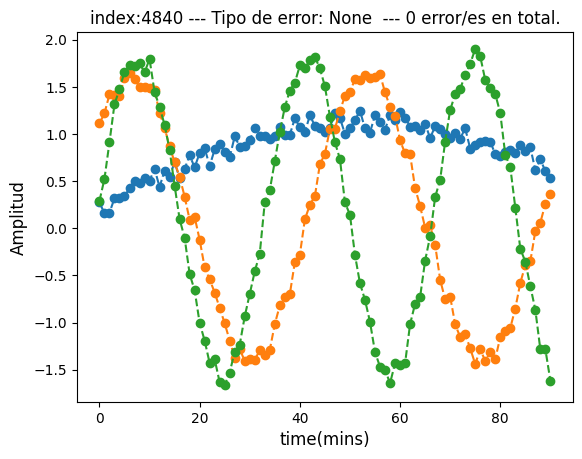

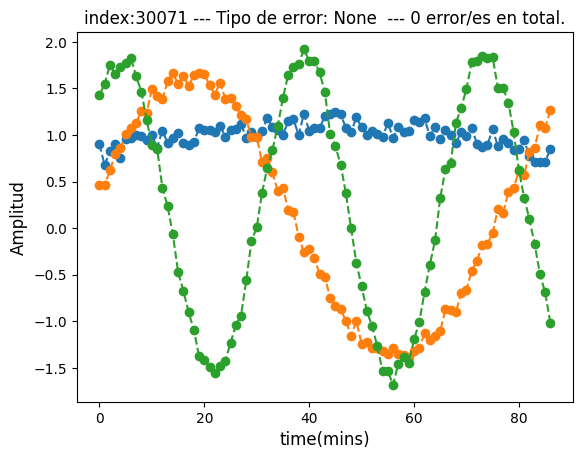

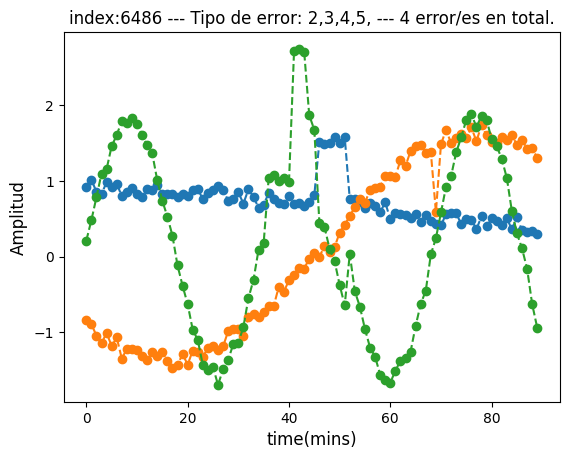

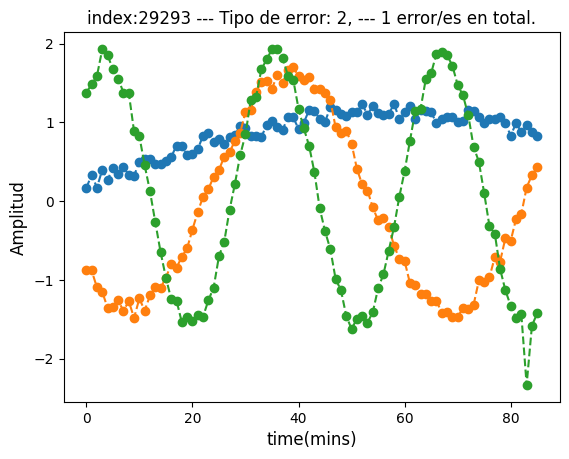

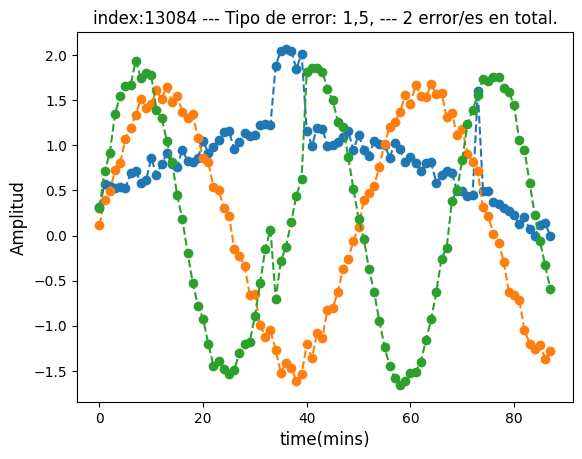

In [24]:
rand_range = np.random.randint(len(xl), size=5)
for i in rand_range:
    sensor_plotter(xl,yl,i)

## Estadístico sobre los datos

Realizamos un estudio estadístico básico de los datos:
  <ul>
    <li> Convierte los labels booleanos en numéricos <code>False -> 0.</code> y <code>True -> 1.</code>. </li>
    <li>Probabilidad de aparición de cada tipo de error. Hacemos un histograma para la clase con menor probabilidad de aparición.</li>
    <li>Longitud media, máxima y mínima de las lecturas de los sensores. Histograma para las longitudes y determina que tipo de distribución genera las diferentes logitudes en las lecturas de los sensores.</li>
  </ul>


In [25]:
y = np.array(yl, dtype = float)
y_len = np.shape(y)[0]

In [26]:
# Longitud media
# ==============================================================================

counts = np.count_nonzero(y, axis=0)/y_len
counts

array([0.17832596, 0.26935775, 0.10191242, 0.32681326, 0.45816981])

([<matplotlib.axis.XTick at 0x7a8ff37c5940>,
 [Text(0, 0, 'False'), Text(1, 0, 'True')])

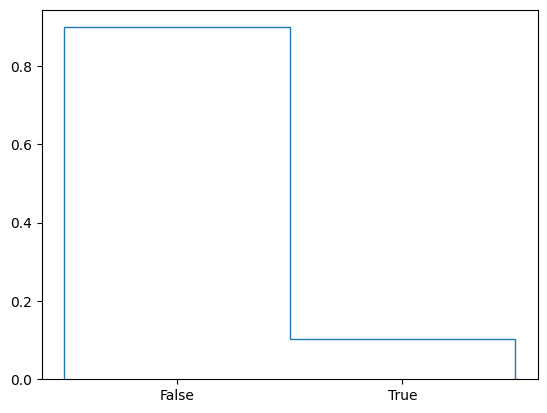

In [27]:
plt.hist(y.transpose()[2],bins=np.arange(3) - 0.5, histtype="step", density=True)
plt.xticks(np.arange(2),['False','True'])

avg_length:  90
min_length: 78
max_length: 101


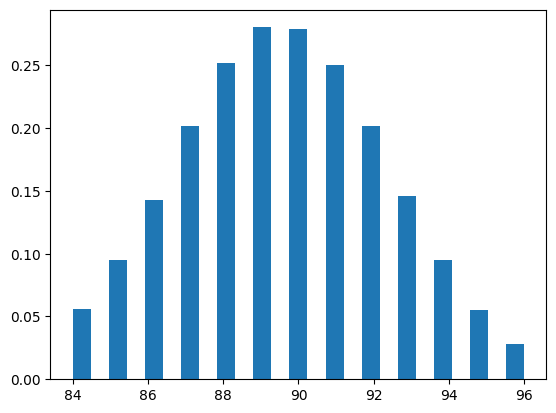

In [28]:
lengths = [sensor_read.shape[0] for sensor_read in xl]
avg_length = round(np.mean(lengths))
print('avg_length: ',avg_length)
min_length = round(np.min(lengths))
print('min_length:', min_length)
max_length = round(np.max(lengths))
print('max_length:', max_length)
plt.hist(lengths, bins = 25, range=(84, 96), histtype="bar", density=True)
plt.show()

## 1.4 Uniformizando la longitud de los datos

Dado que las lecturas de los sensores tiene longitudes variables, necesitamos estandarizarlas. Para esta sección, hay varias opciones pero empezaremos por la más sencilla:
  <ul>
    <li>Las lecturas con tiempos mayores a la media, las cortaremos.</li>
    <li>Las lecturas con medias menores a las medias, las completaremos con el valor médio de cada sensor.</li>
  </ul>
<p>Después de este proceso, seleccionamis un caso de tiempo mayor y uno menor y visualizalos usando la función <code>sensor_plotter</code>.

In [29]:
x = []

for sensor_read in xl:
    length = sensor_read.shape[0]
    if length < avg_length:
        mean_for_each_sensor  = sensor_read.mean(axis = 0)[np.newaxis]
        new_data = np.repeat(mean_for_each_sensor, avg_length - length, axis = 0)
        x.append(np.concatenate([sensor_read, new_data], axis = 0))
    else:
        x.append(sensor_read[:avg_length])
x = np.array(x)

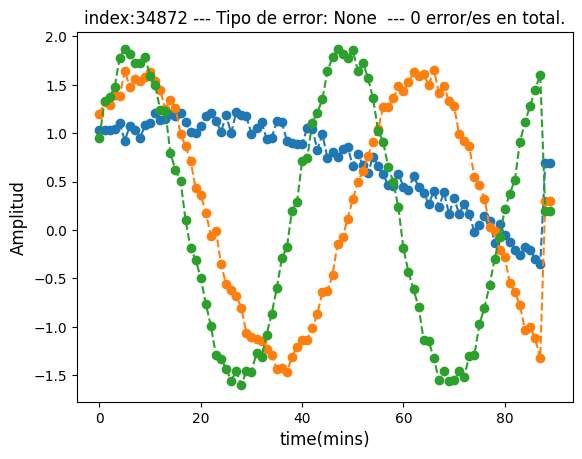

In [30]:
sensor_plotter(x,yl,34872)

In [31]:
# Indica las dimensiones de los datos y los labels
print(x.shape, y.shape)

(48159, 90, 3) (48159, 5)


## Data split para clasificación

Antes de empezar con la construcción de un modelo de clasificación, realizaremos una partición (split) de los datos en 3 grupos:</p>
  <ul>
    <li> 80% para entrenamiento: <code>x_train</code></li>
    <li> 10% para validacion: <code>x_val</code></li>
    <li> 10% para testeo <code>x_test</code></li>
  </ul>
<p>y un <i>shuffle</i> de cada conjunto.</p>
</div>

In [32]:
train_per = 0.8
val_per = 0.1

x_len = len(x)
n_for_train = int(train_per * x_len)
n_for_val = int((train_per + val_per) * x_len)

# _Shuffle
idx = np.arange(x_len)
np.random.shuffle(idx)

x_train, y_train = x[idx[:n_for_train]], y[idx[:n_for_train]]
x_val, y_val = x[idx[n_for_train:n_for_val]], y[idx[n_for_train:n_for_val]]
x_test, y_test = x[idx[n_for_val:]], y[idx[n_for_val:]]

  ## Clasificación

In [33]:
# Definimos el número de sensores de los que disponemos y el número de clases (tipos de errores)
nSensores = x[0].shape[1]
nClases = len(y[0])

In [37]:
y

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])